# Data Understanding and Preparation

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Exploration](#Data-Exploration)
    - [Univariate Analysis](#Univariate-Analysis)
    - [Bivariate Analysis](#Bivariate-Analysis)
3. [Data Preparation](#Data-Preparation)
    - [Deal with Unknown](#Deal-with-Unknown)
    - [Categorical Encoding](#Categorical-Encoding)
    - [Deal with Outliers](#Deal-with-Outliers)
    - [Train-Test Split using Stratified 10-Fold Cross-Validation and SMOTE](#Train-Test-Split-with-Stratified-10-Fold-Cross-Validation-and-SMOTE)
4. [Conclusion](#Conclusion)

## Introduction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('data/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Summary of Dataset
There are 45,211 datapoints and 17 features, and there is no missing values in this dataset but some features could be unknown.

Our purpose is to accurately classify whether the customer will subscribe a term deposit (`y`).
<h4>Input variables:</h4>

1. `age` (numeric)
2. `job` : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. `marital` : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. `education` (categorical: "unknown","secondary","primary","tertiary")
5. `default`: has credit in default? (binary: "yes","no")
6. `balance`: average yearly balance, in euros (numeric) 
7. `housing`: has housing loan? (binary: "yes","no")
8. `loan`: has personal loan? (binary: "yes","no")
9. `contact`: contact communication type (categorical: 'cellular','telephone') 
10. `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11. `day`: last contact day of the month (numeric)
12. `duration`: last contact duration, in seconds (numeric).
    - **Important note:**  this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
13. `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. `previous`: number of contacts performed before this campaign and for this client (numeric)
16. `poutcome`: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

<h4>Output variable (desired target):</h4>

`y` - has the client subscribed a term deposit? (binary: 'yes','no')

In [4]:
# As mentioned in the important note, we drop duration
df = df.drop(columns=['duration'])

In [5]:
# Change `y` to `subscribed` for clarification
df.rename(columns={'y': 'subscribed'}, inplace=True)

## Data Exploration

In [6]:
numerical = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome', 'subscribed']

In [7]:
sb.set_palette('Spectral')

spectral = sb.color_palette('Spectral', 11)

### Univariate Analysis

#### Numerical Variables

In [8]:
df_transpose = df.describe().T
df_transpose

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


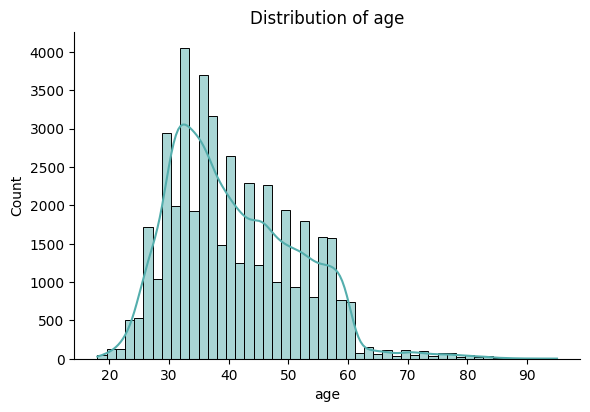

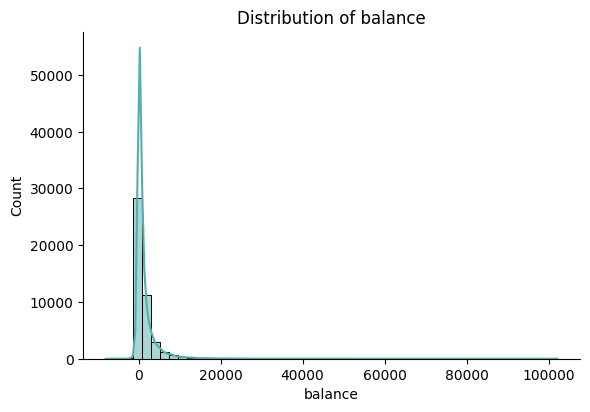

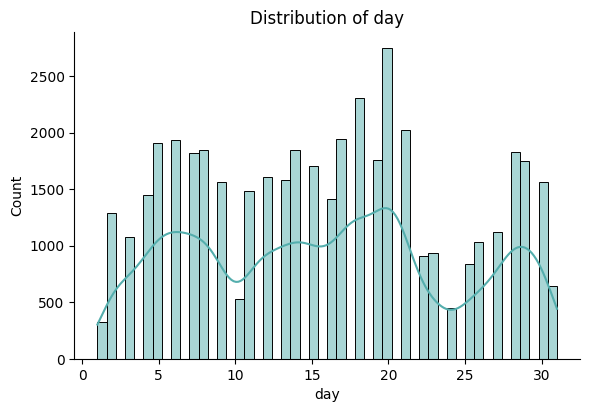

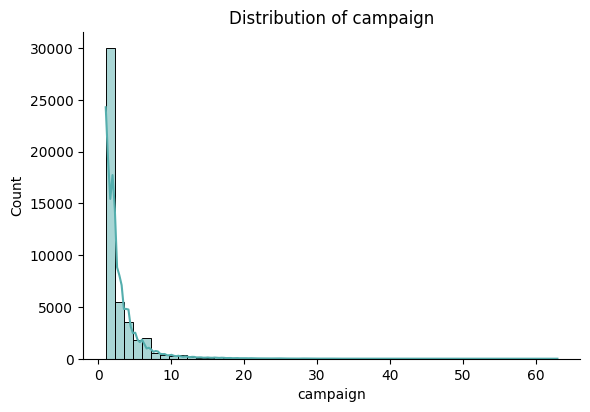

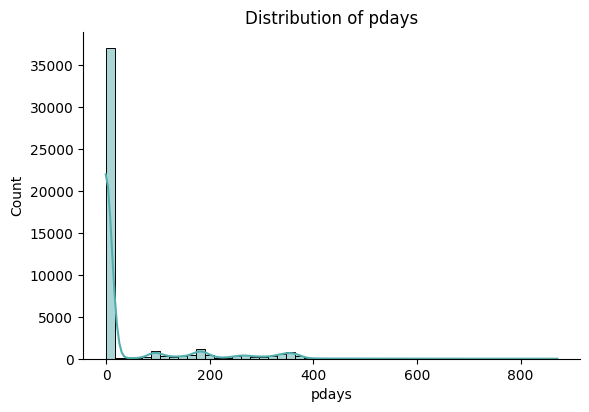

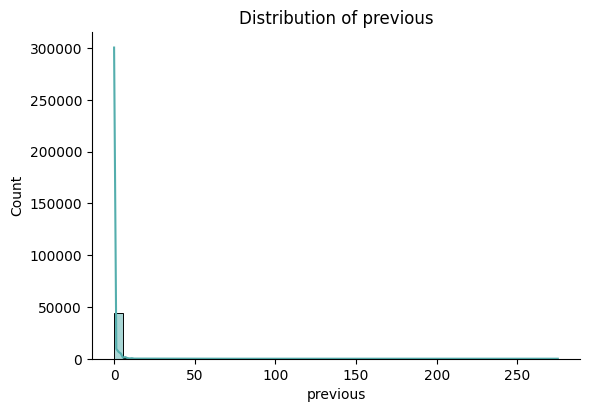

In [9]:
# Distribution KDE Plot
for i in numerical:
    sb.displot(data=df, x=i, kde=True, bins=50, aspect=1.5, height=4, color=spectral[-2])
    plt.title(f'Distribution of {i}')
    plt.show()

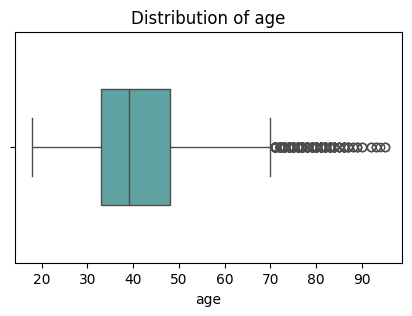

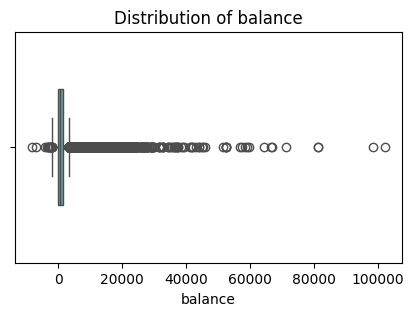

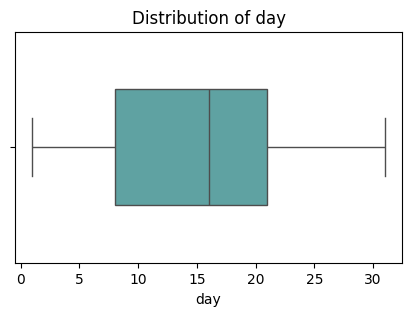

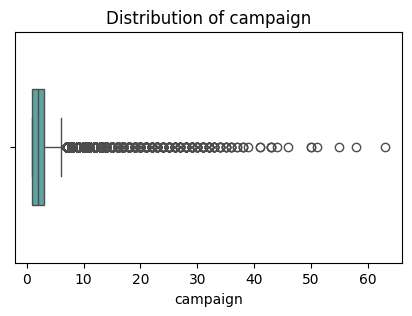

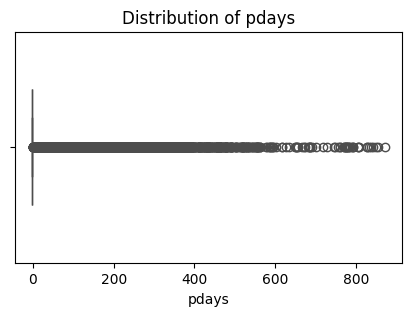

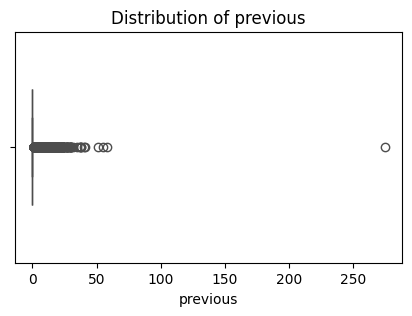

In [10]:
# Box Plot
for i in numerical:
    plt.figure(figsize=(5, 3))
    sb.boxplot(data=df, x=i, width=.5, color=spectral[-2])
    plt.title(f'Distribution of {i}')
    plt.show()

#### Categorical Variables

In [11]:
pd.set_option('display.max_columns', None)

for i in categorical:
    value_counts = df[i].value_counts()
    value_counts_df = value_counts.reset_index()
    print(f'Distribution of {i}')
    display(value_counts_df.T)
    print('\n')

pd.reset_option('display.max_columns')

Distribution of job


,0,1,2,3,4,5,6,7,8,9,10,11
job,blue-collar,management,technician,admin.,services,retired,self-employed,entrepreneur,unemployed,housemaid,student,unknown
count,9732,9458,7597,5171,4154,2264,1579,1487,1303,1240,938,288




Distribution of marital


,0,1,2
marital,married,single,divorced
count,27214,12790,5207




Distribution of education


,0,1,2,3
education,secondary,tertiary,primary,unknown
count,23202,13301,6851,1857




Distribution of default


,0,1
default,no,yes
count,44396,815




Distribution of housing


,0,1
housing,yes,no
count,25130,20081




Distribution of loan


,0,1
loan,no,yes
count,37967,7244




Distribution of contact


,0,1,2
contact,cellular,unknown,telephone
count,29285,13020,2906




Distribution of month


,0,1,2,3,4,5,6,7,8,9,10,11
month,may,jul,aug,jun,nov,apr,feb,jan,oct,sep,mar,dec
count,13766,6895,6247,5341,3970,2932,2649,1403,738,579,477,214




Distribution of day


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
day,20,18,21,17,6,5,14,8,28,7,19,29,15,12,13,30,9,11,4,16,2,27,3,26,23,22,25,31,10,24,1
count,2752,2308,2026,1939,1932,1910,1848,1842,1830,1817,1757,1745,1703,1603,1585,1566,1561,1479,1445,1415,1293,1121,1079,1035,939,905,840,643,524,447,322




Distribution of poutcome


,0,1,2,3
poutcome,unknown,failure,other,success
count,36959,4901,1840,1511




Distribution of subscribed


,0,1
subscribed,no,yes
count,39922,5289


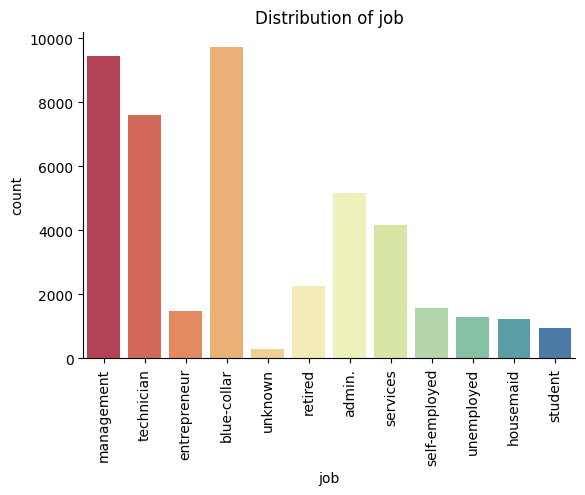

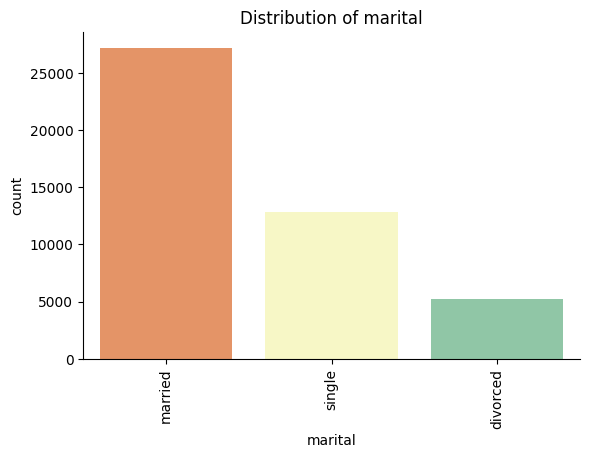

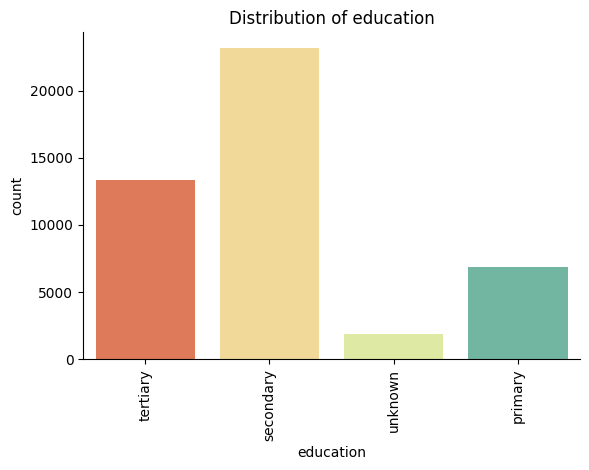

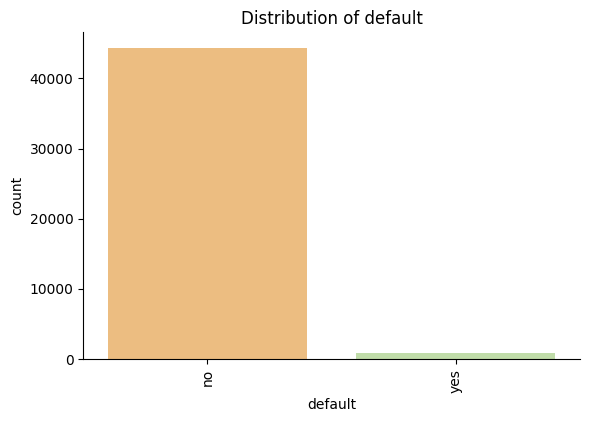

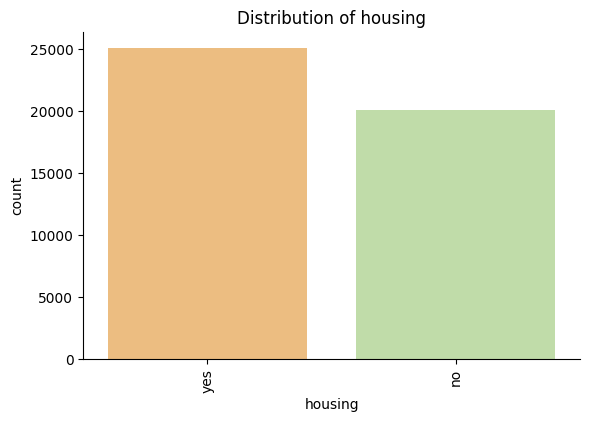

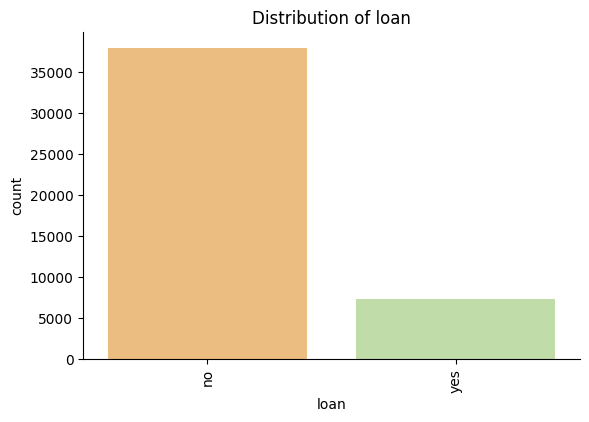

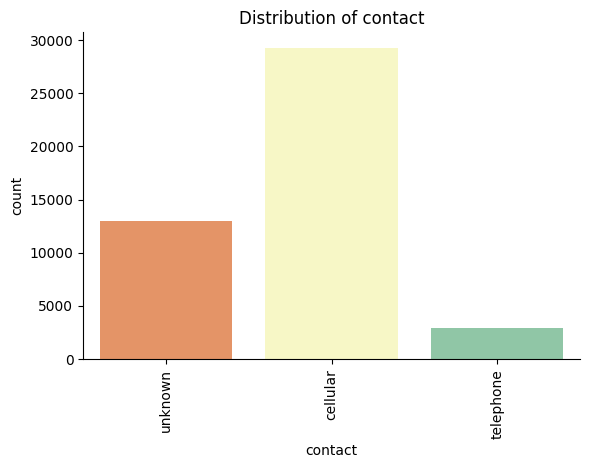

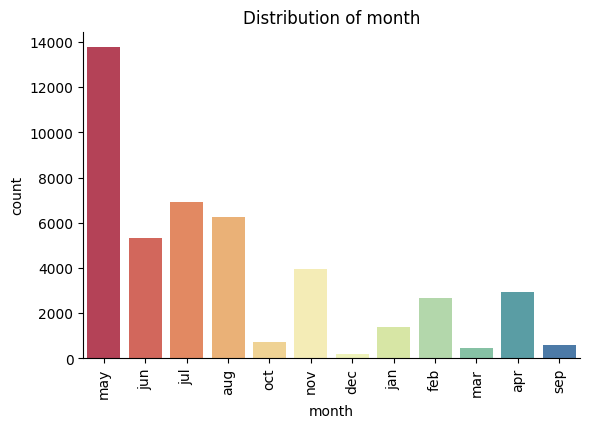

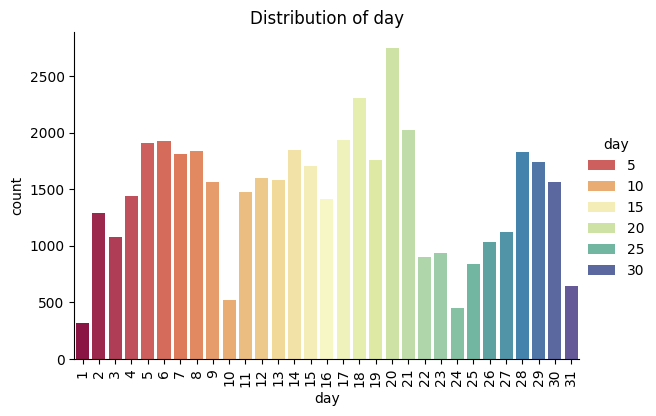

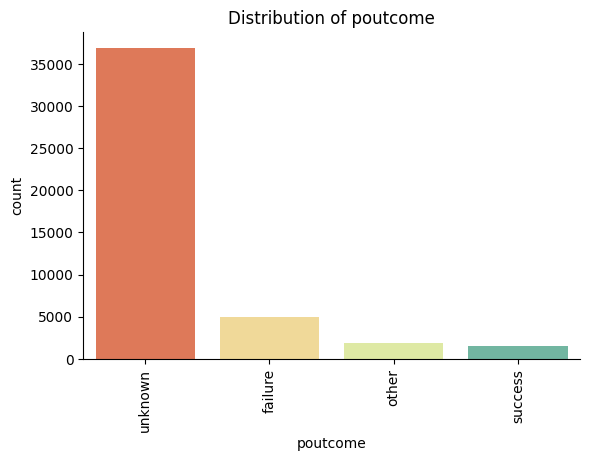

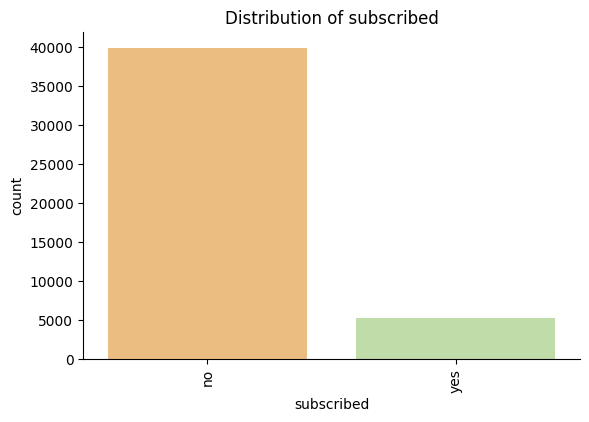

In [12]:
for i in categorical:
    g = sb.catplot(data=df, x=i, kind='count', aspect=1.5, height=4, hue=i, palette='Spectral')
    g.set_xticklabels(rotation=90)
    plt.title(f'Distribution of {i}')
    plt.show()

### Bivariate Analysis

#### Numerical Variables (vs. `subscribed`)

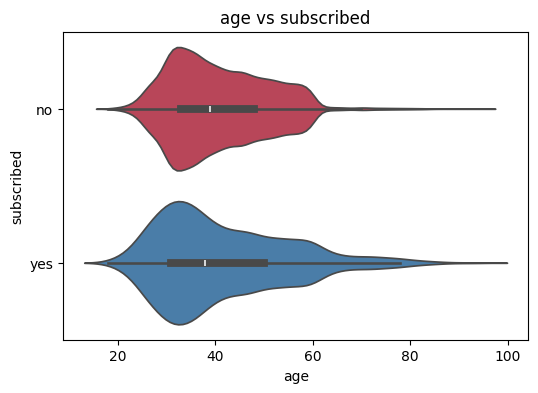

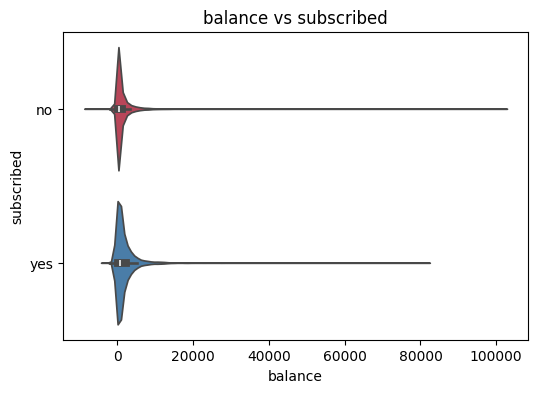

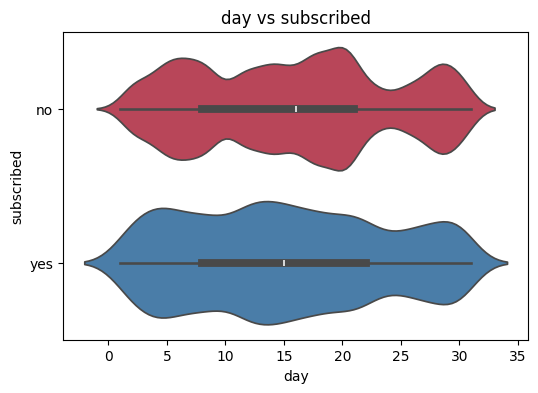

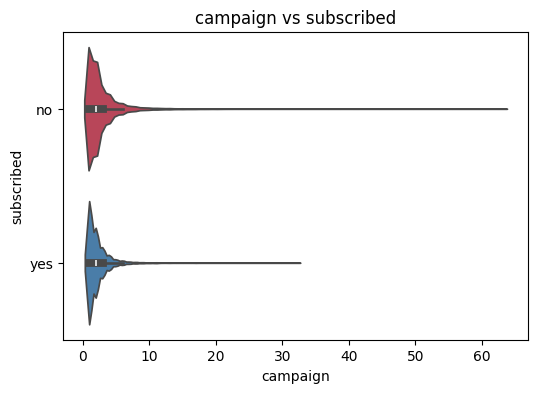

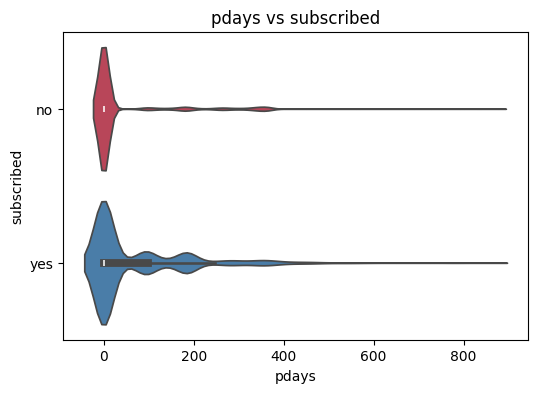

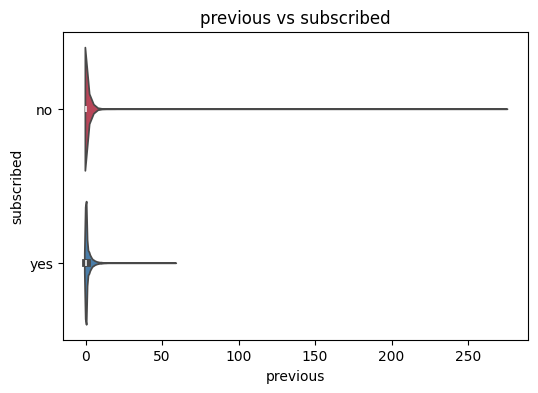

In [13]:
for i in numerical:
    plt.figure(figsize=(6, 4))
    sb.violinplot(data=df, x=i, y='subscribed', hue='subscribed', palette=[spectral[0], spectral[-1]])
    plt.title(f'{i} vs subscribed')
    plt.show()

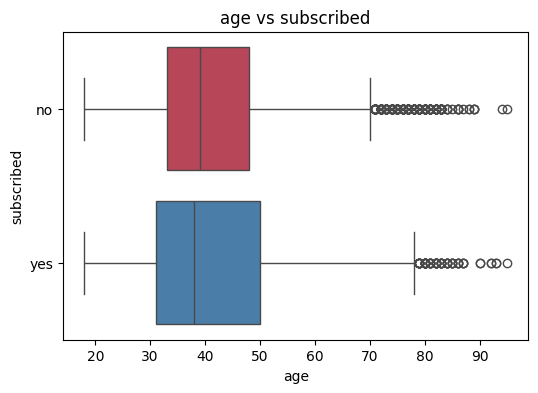

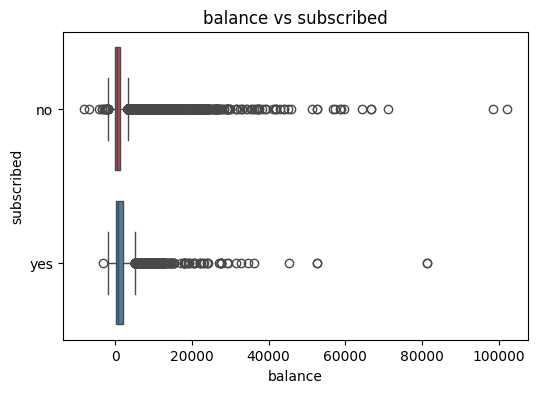

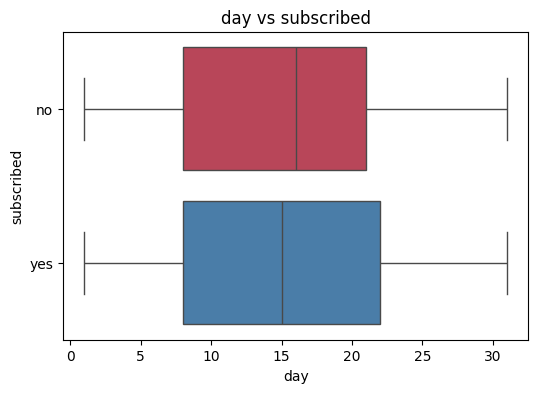

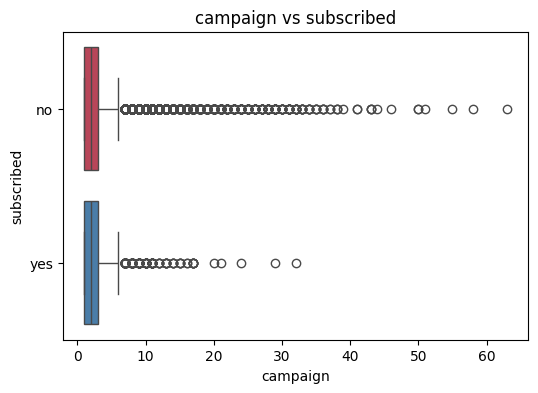

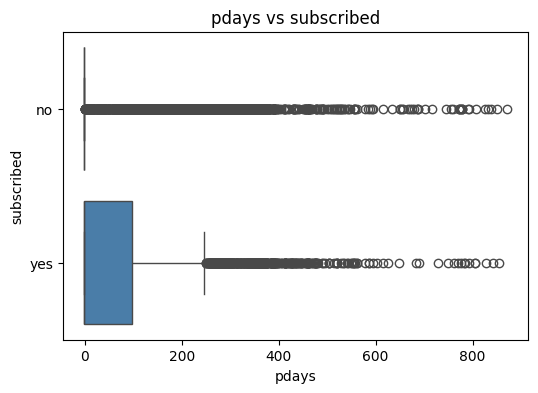

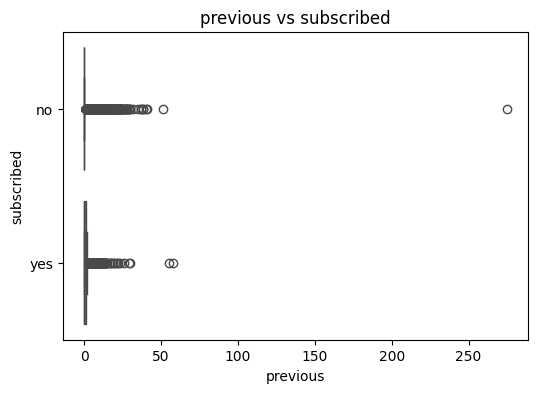

In [14]:
for i in numerical:
    plt.figure(figsize=(6, 4))
    sb.boxplot(data=df, x=i, y='subscribed', hue='subscribed', palette=[spectral[0], spectral[-1]]) 
    plt.title(f'{i} vs subscribed')
    plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

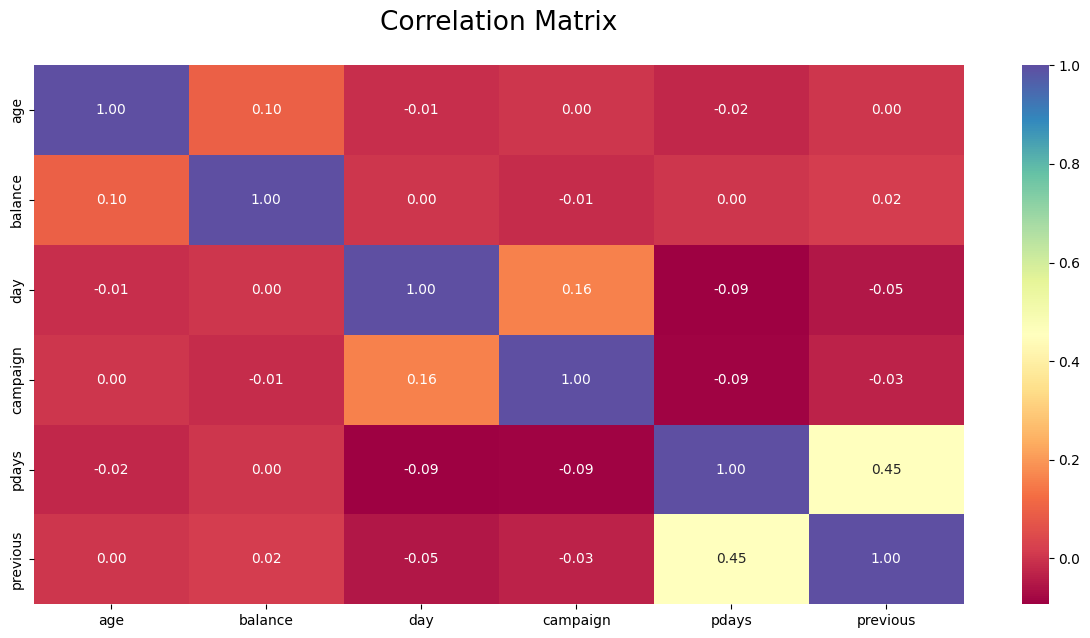

In [15]:
plt.figure(figsize = (15,7))
plt.title('Correlation Matrix', y=1.05, size=19)
sb.heatmap(df[numerical].corr(), cmap='Spectral', annot=True, fmt='.2f')

#### Categorical Variables (vs. `subscribed`)

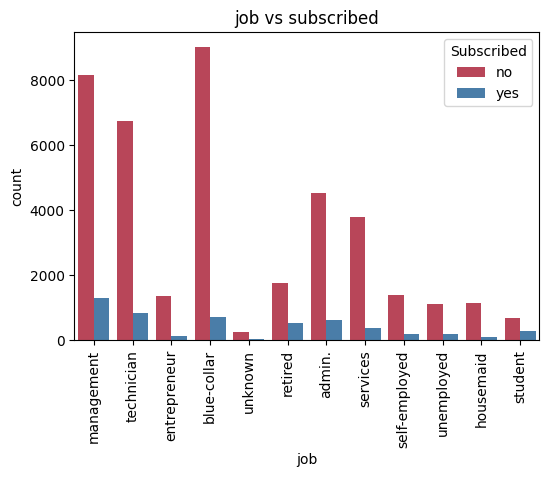

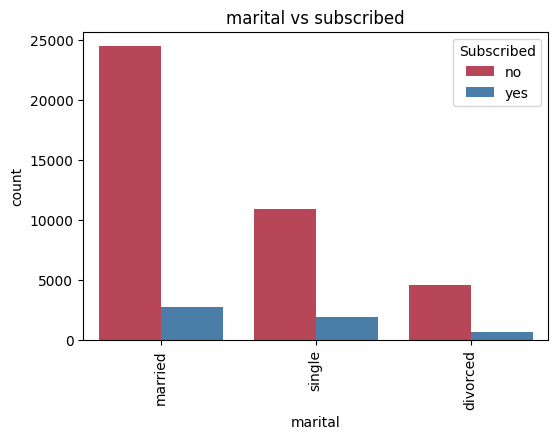

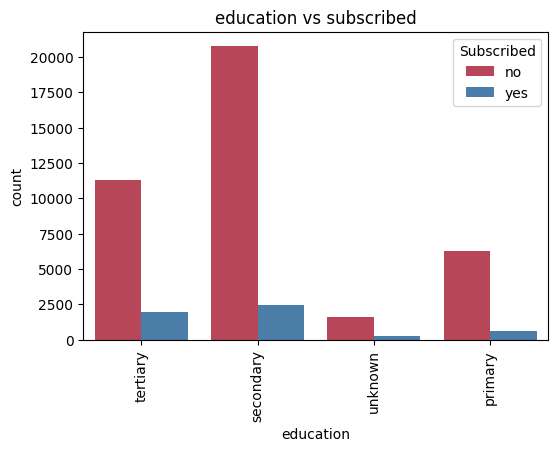

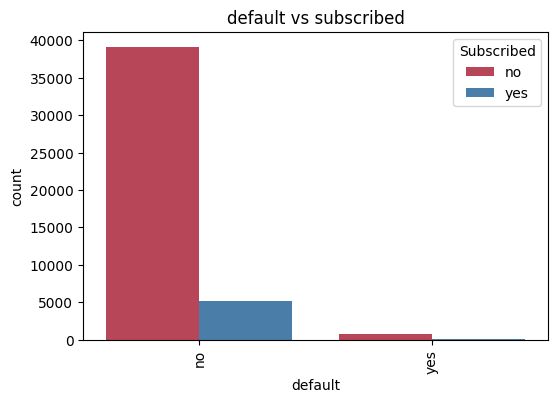

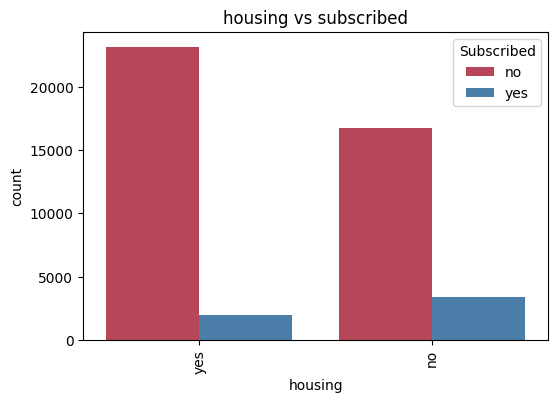

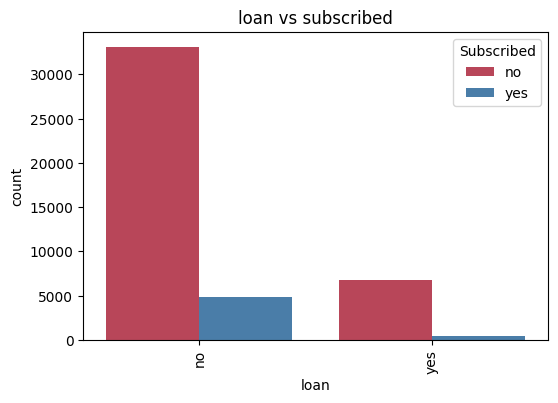

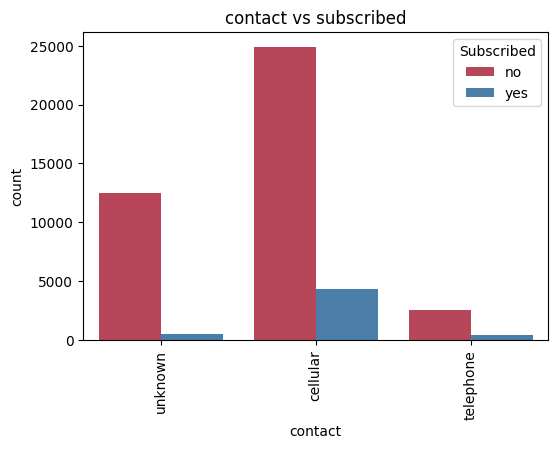

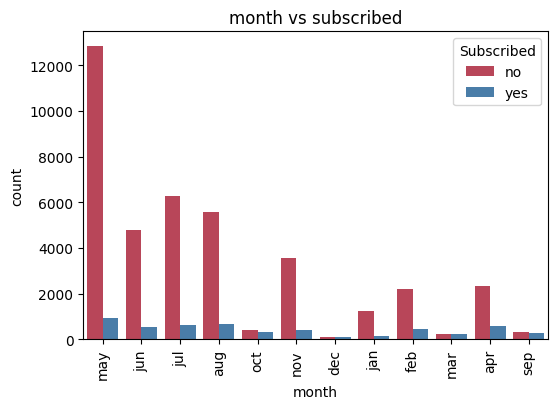

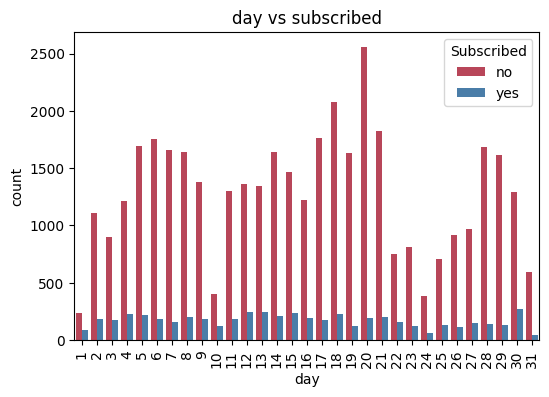

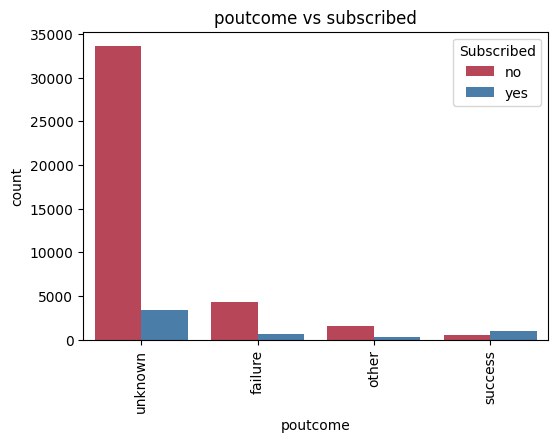

In [16]:
for i in categorical:
    if i == 'subscribed':
        continue
    plt.figure(figsize=(6, 4))
    sb.countplot(data=df, x=i, hue='subscribed', palette=[spectral[0], spectral[-1]])
    plt.title(f'{i} vs subscribed')
    plt.legend(title='Subscribed')
    plt.xticks(rotation=90) 
    plt.show()

## Data Preparation

### Deal with Unknown

To deal with missing values, we decided to impute them using **mode** for `job` and `education`, and leave as a separate category for `contact` and `poutcome` since they have higher number of unknown.

In [17]:
for i in ['job', 'education']:
    mode_value = df[i].mode()[0]
    df[i] = df[i].replace('unknown', mode_value)

### Categorical Encoding

#### Ordinal encoding

In [18]:
education_order = ['primary', 'secondary', 'tertiary']
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = list(range(1, 32))

df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
df['education_encoded'] = df['education'].cat.codes
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df['month_encoded'] = df['month'].cat.codes
df['day'] = pd.Categorical(df['day'], categories=day_order, ordered=True)
df['day_encoded'] = df['day'].cat.codes

df = df.drop(columns=['education', 'month', 'day'])

#### Nominal encoding

In [19]:
df = pd.get_dummies(df, columns=[var for var in categorical if var not in ['education', 'month', 'day', 'subscribed']], drop_first=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                45211 non-null  int64 
 1   balance            45211 non-null  int64 
 2   campaign           45211 non-null  int64 
 3   pdays              45211 non-null  int64 
 4   previous           45211 non-null  int64 
 5   subscribed         45211 non-null  object
 6   education_encoded  45211 non-null  int8  
 7   month_encoded      45211 non-null  int8  
 8   day_encoded        45211 non-null  int8  
 9   job_blue-collar    45211 non-null  bool  
 10  job_entrepreneur   45211 non-null  bool  
 11  job_housemaid      45211 non-null  bool  
 12  job_management     45211 non-null  bool  
 13  job_retired        45211 non-null  bool  
 14  job_self-employed  45211 non-null  bool  
 15  job_services       45211 non-null  bool  
 16  job_student        45211 non-null  bool 

### Deal with Outliers

We will remove outliers for `balance` and `campaign`, since `pdays` and `previous` majority are outliers.

In [21]:
for i in ['balance', 'campaign']:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df[i] = df[i].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

### Train-Test Split with Stratified 10 Fold Cross-Validation and SMOTE

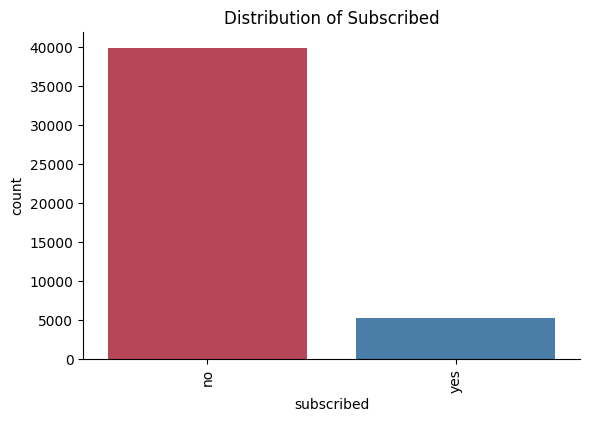

In [22]:
g = sb.catplot(data=df, x='subscribed', kind='count', aspect=1.5, height=4, hue='subscribed', palette=[spectral[0], spectral[-1]])
g.set_xticklabels(rotation=90)
plt.title(f'Distribution of Subscribed')
plt.show()

As our target variable has an unbalanced distribution that could lead to model bias, we will set up <a href='https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html'>Stratified 10 Fold Cross-Validation</a>, which is a more advanced form of cross-validation, to ensure that each fold has the same proportion of classes as the original dataset.

Moreover, to prevent the model from becoming biased toward the majority class of the training set for each fold, we will apply <a href='https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html'>Synthetic Minority Over-sampling Technique (SMOTE)</a>, which creates synthetic data points for the minority class with the same features' distribution of the original dataset. This helps the model to learn from a more balanced dataset.

In [23]:
import os
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

X = df.drop('subscribed', axis=1)
y = df['subscribed']
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
export_dir = f'./data/train-test/'

for fold, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    # Train-Test split based on Stratified 10 Fold CV
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE for training set
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Export train-test data
    fold_dir = export_dir + f'fold_{fold}'
    os.makedirs(fold_dir, exist_ok=True)
    train_data = pd.concat([X_resampled, y_resampled], axis=1)
    test_data = pd.concat([X_val, y_val], axis=1)
    
    train_data.to_csv(f'{fold_dir}/train_data_fold_{fold}.csv', index=False)
    test_data.to_csv(f'{fold_dir}/test_data_fold_{fold}.csv', index=False)

## Conclusion

In this notebook, we explored the dataset, examined the distribution of each feature with and without comparison to the target variable, and handled missing values and outliers. We also encoded categorical variables and prepared the train and test datasets using Stratified 10-Fold Cross-Validation and SMOTE to address the imbalance in the target variable. The prepared datasets were exported as CSV files for further use in model training. Next, we will use these 10 prepared datasets to train our model.